# SVRegressor Evaluation

## read fold results and print as table

In [11]:
# load config file
import os
import yaml
import pandas as pd

config_path = os.path.join("..", "..", "Config", "SVR", "configs.yaml")

with open(config_path, 'r') as file:
    config = yaml.safe_load(file)
    
last_run_folder = config.get('last_run_folder', None)
output_folder = config.get('output_dir', None)

last_run_folder = os.path.join("..", "..", output_folder, last_run_folder)

# load results.csv
df = pd.read_csv(os.path.join(last_run_folder, "results.csv"))

# print the results sorted by rmse
df_sorted = df.sort_values(by='test_rmse')
print(df_sorted.to_string(index=False))

# read the median_params.yaml
median_params_path = os.path.join(last_run_folder, "median_params.yaml")
with open(median_params_path, 'r') as file:
    median_params = yaml.safe_load(file)
    
# print the median parameters
print("\nMedian Parameters:")
for key, value in median_params.items():
    print(f"{key}: {value}")

# print the median results
median_results = df_sorted.iloc[len(df_sorted) // 2]
print("\nMedian Results:")
for key, value in median_results.items():
    print(f"{key}: {value}")



 fold    train_rmse    test_rmse     train_mae      test_mae  train_r2   test_r2
    4 163104.743433 2.813324e+05  84970.077191 164245.046868  0.890950  0.036823
    5 165141.853594 3.077302e+05  82387.371761 170894.266324  0.881118  0.396359
    2 288293.869919 3.151403e+05 129210.096317 133685.501544  0.592369  0.622840
    1 245870.403459 4.659189e+05 105278.645592 242307.882663  0.615238  0.449877
    3 279316.346636 1.026674e+06 132613.026505 404218.482913  0.672440 -7.969503

Median Parameters:
C: 9.999254732911725
epsilon: 0.55
kernel: linear

Median Results:
fold: 2.0
train_rmse: 288293.8699191441
test_rmse: 315140.2507619664
train_mae: 129210.0963170506
test_mae: 133685.50154445227
train_r2: 0.5923694221907869
test_r2: 0.6228396668350425


We select the median hyperparameter set, perform cross-validation on the dataset using these parameters, and save the resulting predictions.

## plot predictions

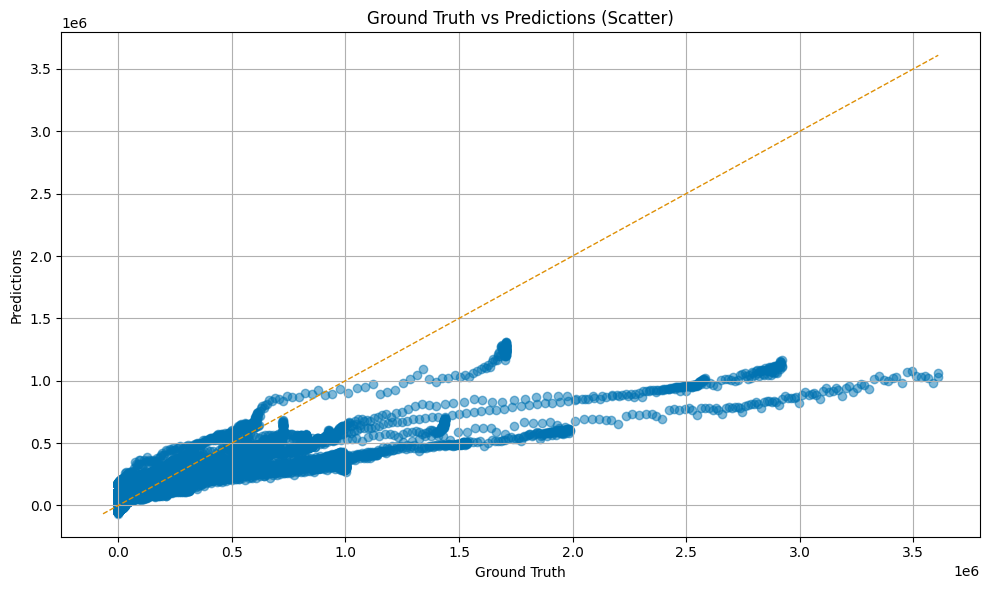

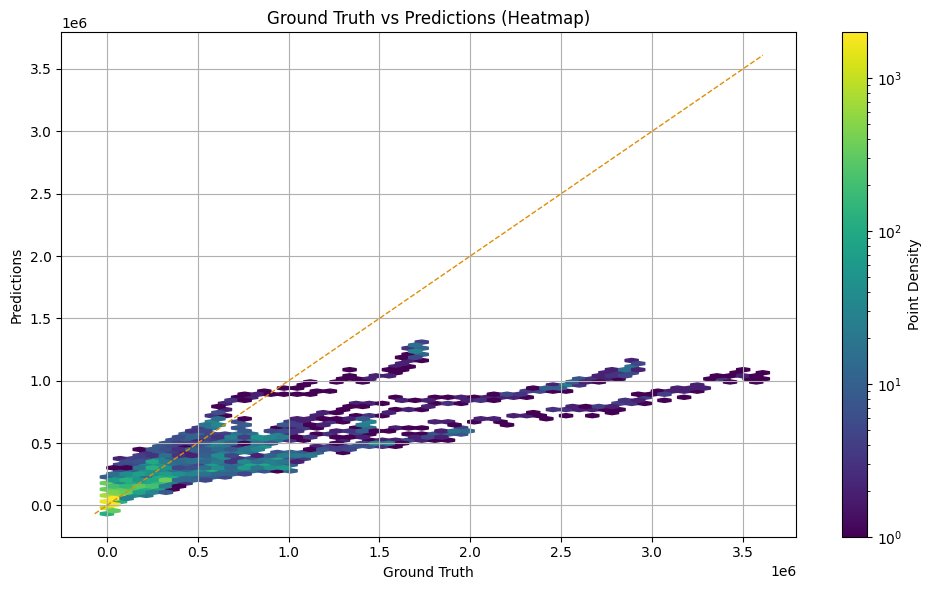

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

path_to_data = os.path.join(last_run_folder, "gt_vs_predictions.csv")

df = pd.read_csv(path_to_data)

# Use seaborn colorblind palette for scatter plot
palette = sns.color_palette("colorblind")
plt.figure(figsize=(10, 6))
plt.scatter(df["ground_truth"], df["predictions"], alpha=0.5, color=palette[0])
min_val = min(df["ground_truth"].min(), df["predictions"].min())
max_val = max(df["ground_truth"].max(), df["predictions"].max())
plt.plot([min_val, max_val], [min_val, max_val], color=palette[1], linestyle='--', linewidth=1)
plt.xlabel("Ground Truth")
plt.ylabel("Predictions")
plt.title("Ground Truth vs Predictions (Scatter)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2D Histogram (Heatmap) using a perceptually uniform, colorblind-friendly colormap
plt.figure(figsize=(10, 6))
hb = plt.hexbin(
    df["ground_truth"], df["predictions"],
    gridsize=50, cmap="viridis", bins='log'  # "viridis" is smooth and colorblind-friendly
)
plt.colorbar(hb, label='Point Density')
plt.plot([min_val, max_val], [min_val, max_val], color=palette[1], linestyle='--', linewidth=1)
plt.xlabel("Ground Truth")
plt.ylabel("Predictions")
plt.title("Ground Truth vs Predictions (Heatmap)")
plt.grid(True)
plt.tight_layout()
plt.show()

The results are terrible overall.

## Calculate RMSE and R^2 over the whole data

In [13]:
from sklearn.metrics import root_mean_squared_error, r2_score

rmse = root_mean_squared_error(df["ground_truth"], df["predictions"])
mae = (df["ground_truth"] - df["predictions"]).abs().mean()
r2 = r2_score(df["ground_truth"], df["predictions"])

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R^2: {r2:.4f}")

RMSE: 308219.64
MAE: 140077.65
R^2: 0.5590


# Statistical analysis

In [14]:

# print percentage of gt = 0 from the whole dataset
percentage_gt_zero = (df["ground_truth"] == 0).mean() * 100
print(f"Percentage of ground truth values equal to 0: {percentage_gt_zero:.2f}%")

# mean and std of ground truth
mean_gt = df["ground_truth"].mean()
std_gt = df["ground_truth"].std()
print(f"Mean of ground truth: {mean_gt:.2f}")
print(f"Standard deviation of ground truth: {std_gt:.2f}")


Percentage of ground truth values equal to 0: 8.50%
Mean of ground truth: 251306.03
Standard deviation of ground truth: 464122.42


The MAE and RMSE of the model are not far from just gessing the mean.
This makes this model not reliable in general

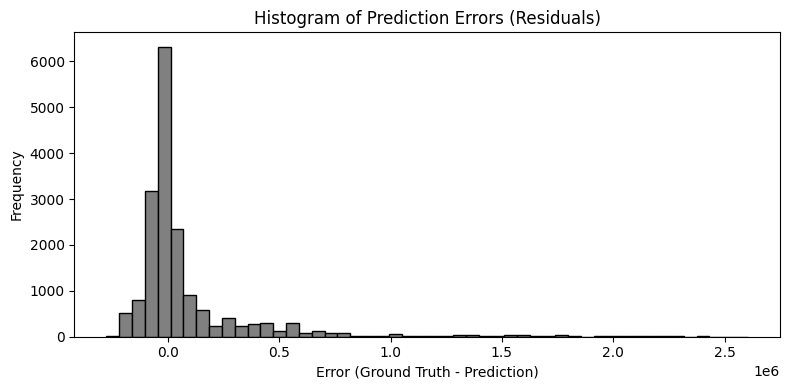

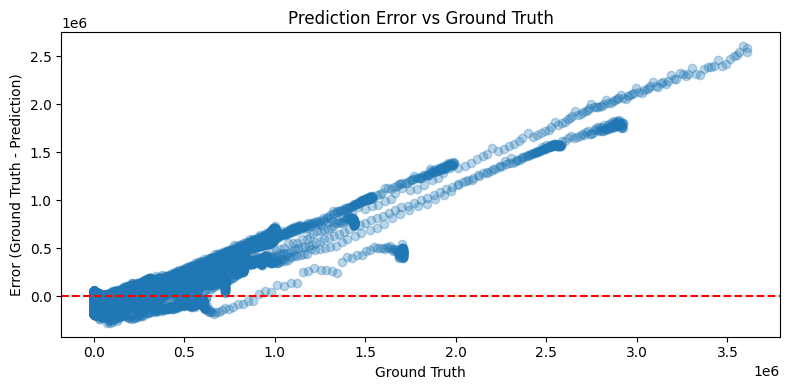

In [15]:
# Calculate errors (residuals)
errors = df["ground_truth"] - df["predictions"]

# Plot histogram of errors
plt.figure(figsize=(8, 4))
plt.hist(errors, bins=50, color='gray', edgecolor='black')
plt.title("Histogram of Prediction Errors (Residuals)")
plt.xlabel("Error (Ground Truth - Prediction)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()
# Optional: Plot errors vs ground truth
plt.figure(figsize=(8, 4))
plt.scatter(df["ground_truth"], errors, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.title("Prediction Error vs Ground Truth")
plt.xlabel("Ground Truth")
plt.ylabel("Error (Ground Truth - Prediction)")
plt.tight_layout()
plt.show()

The errors seem to have a particular shape, a domain expert is needed to interpret the reason.

## Limitations

SVR has several limitations for this kind of data. It can struggle to capture complex or highly variable patterns, especially when the data comes from different regions or groups. 
SVR is also sensitive to feature scaling and the choice of kernel and hyperparameters. 
If the new data is very different from what the model has seen, predictions can be unreliable. 
Finally, SVR is computationally heavy and does not scale well to large datasets, making it hard to use for bigger problems.

## SHAP

  0%|          | 0/100 [00:00<?, ?it/s]

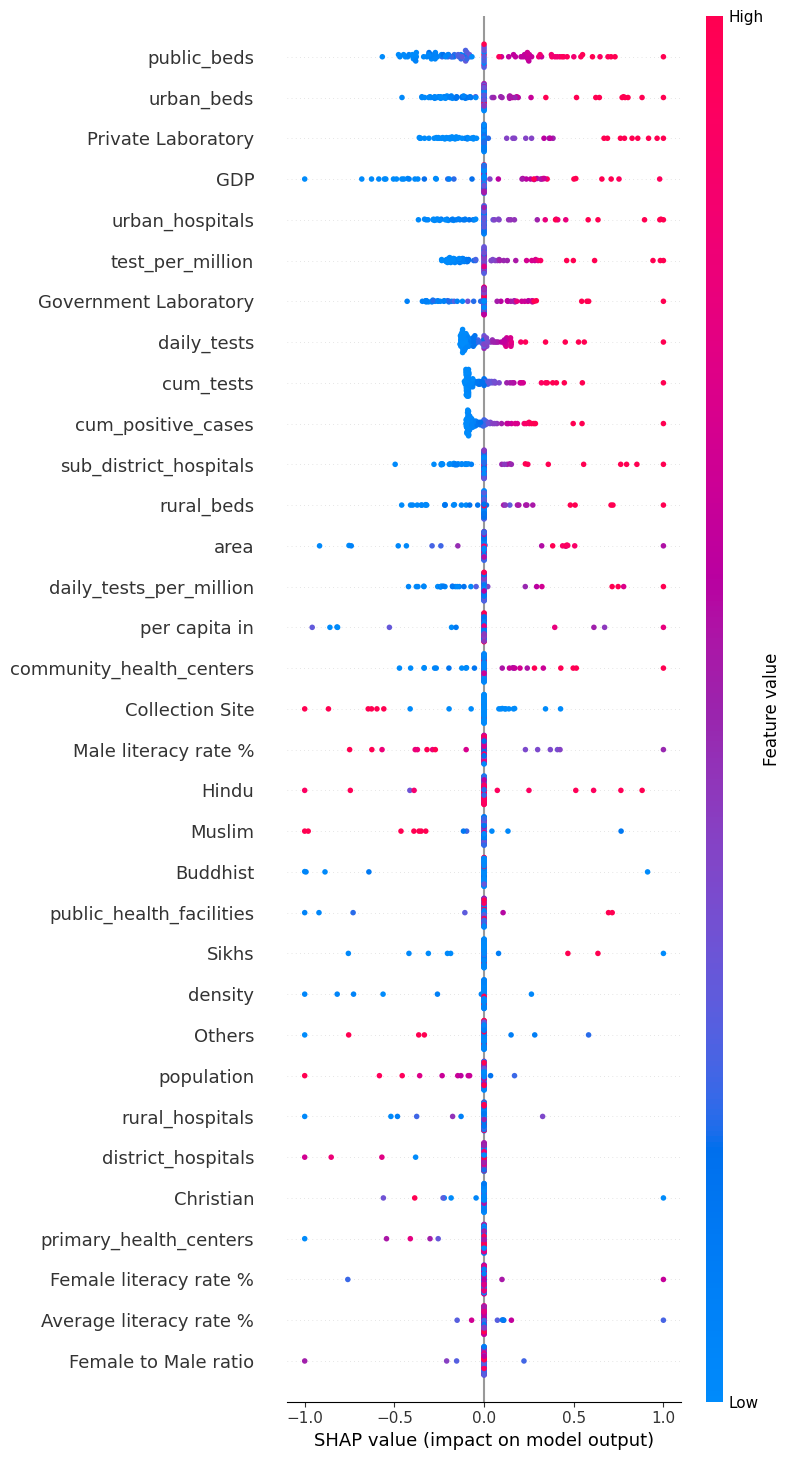

In [18]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", message="X does not have valid feature names")
import shap
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import os

train_data = pd.read_csv(os.path.join("..", "..", config.get('data_path')))
X = train_data.drop(columns=['target', 'dates', 'state'])
y = train_data['target']

# Recreate and fit the model with the median parameters on all data
model = make_pipeline(StandardScaler(), SVR(**median_params))
model.fit(X, y)

# Take a random sample of 100 rows for SHAP analysis and as background
X_sample = X.sample(100, random_state=0)

# Define a wrapper function for prediction
def pipeline_predict(X_array):
    return model.predict(X_array)

explainer = shap.KernelExplainer(pipeline_predict, X_sample)
shap_values = explainer.shap_values(X_sample, nsamples=100)

# Normalize each feature's SHAP values by its max absolute value
shap_vals_norm = shap_values / (np.abs(shap_values).max(axis=0) + 1e-10)
shap.summary_plot(shap_vals_norm, X_sample, feature_names=X.columns, max_display=X.shape[1])

As the model is inaccurate we can't rely on the SHAP evaluation.